In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import operator
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Conv2D, Dense, Dropout, BatchNormalization, Flatten, MaxPooling1D, LeakyReLU
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from math import floor
from sklearn.metrics import make_scorer, accuracy_score
# from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold

# If you still want to explicitly use LeakyReLU
LeakyReLU = LeakyReLU(alpha=0.1)

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [2]:
pip install bayesian-optimization


Note: you may need to restart the kernel to use updated packages.


In [3]:
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [6]:
import warnings
warnings.simplefilter('ignore')

# sns.pairplot(X_full[['species', 'sepal_length', 'sepal_width', 'petal_length', 'petal_width']], hue = 'species')
# plt.show()

In [8]:
path = r'/Users/urvi/Desktop/Machine Learning with Python/Achivement 2/Climate wins 2/Data'

# Import and Resize Data

## Import X data

In [9]:
X_full = pd.read_csv(os.path.join(path,'Original data ', 'DATASET weather_prediction_imputed.csv'), index_col=False)

In [10]:
X_full.drop(columns=["YEAR", "MONTH", "DAY"], inplace=True)

### Convert to Array

In [11]:
X_full = X_full.to_numpy()
X_full.shape

(22950, 135)

### Resize to (-1, 15, 9)

In [12]:
X_full = X_full.reshape(-1,15,9)
X_full.shape

(22950, 15, 9)

# Import y data

In [13]:
y_full = pd.read_csv(os.path.join(path,'Original Data ','Dataset-Answers-Weather_Prediction_Pleasant_Weather.csv'), index_col = False)

In [14]:
y_full.drop(columns=["YEAR", "MONTH", "DAY"], inplace=True)

### Convert to array

In [15]:
y_full = y_full.to_numpy()
y_full.shape

(22950, 15)

In [16]:
y_original = y_full

# this is where the change was made

In [17]:
# Use argmax to get rid of on-hot encoding and supply the numerical value.
y_full = np.argmax(y_full, axis = 1)
print(y_full.shape)
y_full

(22950,)


array([0, 0, 0, ..., 0, 0, 0])

### Remove one hot encoding with argmax

# Split into Test and Train Data

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.3, random_state=42)

In [19]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(16065, 15, 9)
(6885, 15, 9)
(16065,)
(6885,)


In [20]:
types = {0:'BASEL_pleasant_weather', 1:'BELGRADE_pleasant_weather',
       2:'BUDAPEST_pleasant_weather', 3:'DEBILT_pleasant_weather',
       4:'DUSSELDORF_pleasant_weather', 5:'HEATHROW_pleasant_weather',
       6:'KASSEL_pleasant_weather', 7:'LJUBLJANA_pleasant_weather',
       8:'MAASTRICHT_pleasant_weather', 9:'MADRID_pleasant_weather',
       10:'MUNCHENB_pleasant_weather', 11:'OSLO_pleasant_weather',
       12:'SONNBLICK_pleasant_weather', 13:'STOCKHOLM_pleasant_weather',
       14:'VALENTIA_pleasant_weather'}

# Optimisation : Bayesian

## y data must be binary or multiclass
## check for data type

from sklearn.utils.multiclass import type_of_target
type_of_target(y_train)

# old y_data reshaping

In [21]:
# # Turn y_test into one-hot format
ty=utils.to_categorical(y_test)
print(ty)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [22]:
# Use argmax to get rid of on-hot encoding and supply the numerical value.
ty = np.argmax(ty, axis = 1)
print(ty.shape)

(6885,)


In [199]:
type_of_target(ty)

'multiclass'

# Bayesian Function

In [200]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = 15
# Make scorer accuracy
score_acc = make_scorer(accuracy_score)
len(X_train[0][0])

9

In [201]:
# Create function
def bay_area(neurons, activation, kernel, optimizer, learning_rate, batch_size, epochs,
              layers1, layers2, normalization, dropout, dropout_rate):
    optimizerL = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','SGD']
    optimizerD= {'Adam':Adam(lr=learning_rate), 'SGD':SGD(lr=learning_rate),
                 'RMSprop':RMSprop(lr=learning_rate), 'Adadelta':Adadelta(lr=learning_rate),
                 'Adagrad':Adagrad(lr=learning_rate), 'Adamax':Adamax(lr=learning_rate),
                 'Nadam':Nadam(lr=learning_rate), 'Ftrl':Ftrl(lr=learning_rate)}
    activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
                   'elu', 'exponential', LeakyReLU,'relu']

    neurons = round(neurons)
    kernel = round(kernel)
    activation = activationL[round(activation)]
    optimizer = optimizerD[optimizerL[round(optimizer)]]
    batch_size = round(batch_size)

    epochs = round(epochs)
    layers1 = round(layers1)
    layers2 = round(layers2)

    def cnn_model():
        model = Sequential()
        model.add(Conv1D(neurons, kernel_size=kernel,activation=activation, input_shape=(timesteps, input_dim)))
        #model.add(Conv1D(32, kernel_size=1,activation='relu', input_shape=(timesteps, input_dim)))

        if normalization > 0.5:
            model.add(BatchNormalization())
        for i in range(layers1):
            model.add(Dense(neurons, activation=activation)) #(neurons, activation=activation))
        if dropout > 0.5:
            model.add(Dropout(dropout_rate, seed=123))
        for i in range(layers2):
            model.add(Dense(neurons, activation=activation))
        model.add(MaxPooling1D())
        model.add(Flatten())
        model.add(Dense(n_classes, activation='softmax')) #sigmoid softmax
        #model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy']) #categorical_crossentropy
        model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy']) #categorical_crossentropy
        return model
    es = EarlyStopping(monitor='accuracy', mode='max', verbose=2, patience=20)
    nn = KerasClassifier(build_fn=cnn_model, epochs=epochs, batch_size=batch_size, verbose=2)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    score = cross_val_score(nn, X_train, Y_train, scoring=score_acc, cv=kfold, fit_params={'callbacks':[es]}).mean()
    return score

## for test, 'init_points' be set as only 10.
## nn_opt.maximize(init_points=10, n_iter=4) #25

In [202]:
import numpy as np
import time
from bayes_opt import BayesianOptimization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, BatchNormalization, Flatten, MaxPooling1D
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Assuming X_train, y_train are already defined and properly shaped
# Ensure you import necessary libraries and define your dataset before this block

def bay_area(neurons, activation, kernel, optimizer, learning_rate, batch_size, epochs,
             layers1, layers2, normalization, dropout, dropout_rate):
    # Convert parameters to appropriate types
    neurons = int(neurons)
    kernel = int(kernel)
    batch_size = int(batch_size)
    epochs = int(epochs)
    layers1 = int(layers1)
    layers2 = int(layers2)

    # Define the model architecture
    model = Sequential([
        Conv1D(neurons, kernel_size=kernel, activation='relu', input_shape=(15, 9)),
        MaxPooling1D(),
        Flatten(),
        Dense(15, activation='softmax')
    ])

    # Choose the optimizer based on input
    optimizer_choices = {
        0: Adam(lr=learning_rate),
        1: SGD(lr=learning_rate),
        2: RMSprop(lr=learning_rate),
        3: Adadelta(lr=learning_rate),
        4: Adagrad(lr=learning_rate),
        5: Adamax(lr=learning_rate),
        6: Nadam(lr=learning_rate),
        7: Ftrl(lr=learning_rate)
    }
    optimizer = optimizer_choices[int(optimizer)]

    # Compile model
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Fit model
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    # Evaluate model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    return accuracy  # Return the accuracy as the metric to maximize

# Set start time
start = time.time()

# Parameters for Bayesian optimization
params = {
    'neurons': (10, 100),
    'kernel': (1, 3),
    'activation': (0, 9),
    'optimizer': (0, 7),
    'learning_rate': (0.01, 1),
    'batch_size': (200, 1000),
    'epochs': (20, 100),
    'layers1': (1, 3),
    'layers2': (1, 3),
    'normalization': (0, 1),
    'dropout': (0, 1),
    'dropout_rate': (0, 0.3)
}

# Initialize Bayesian Optimization
nn_opt = BayesianOptimization(bay_area, params, random_state=42)
nn_opt.maximize(init_points=10, n_iter=4)

# Print total time taken
print('Search completed. Total time: %s minutes' % ((time.time() - start) / 60))


|   iter    |  target   | activa... | batch_... |  dropout  | dropou... |  epochs   |  kernel   |  layers1  |  layers2  | learni... |  neurons  | normal... | optimizer |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------


| 1         | 0.7566    | 3.371     | 960.6     | 0.732     | 0.1796    | 32.48     | 1.312     | 1.116     | 2.732     | 0.6051    | 73.73     | 0.02058   | 6.789     |


| 2         | 0.7755    | 7.492     | 369.9     | 0.1818    | 0.05502   | 44.34     | 2.05      | 1.864     | 1.582     | 0.6157    | 22.55     | 0.2921    | 2.565     |


| 3         | 0.7609    | 4.105     | 828.1     | 0.1997    | 0.1543    | 67.39     | 1.093     | 2.215     | 1.341     | 0.0744    | 95.4      | 0.9656    | 5.659     |


| 4         | 0.2337    | 2.742     | 278.1     | 0.6842    | 0.132     | 29.76     | 1.99      | 1.069     | 2.819     | 0.2662    | 69.63     | 0.3117    | 3.64      |


| 5         | 0.8041    | 4.92      | 347.9     | 0.9696    | 0.2325    | 95.16     | 2.79      | 2.196     | 2.844     | 0.09761   | 27.64     | 0.04523   | 2.277     |


| 6         | 0.7603    | 3.498     | 417.1     | 0.8287    | 0.107     | 42.47     | 2.085     | 1.282     | 2.604     | 0.08381   | 98.82     | 0.7722    | 1.391     |


| 7         | 0.7673    | 0.0497    | 852.4     | 0.7069    | 0.2187    | 81.7      | 1.148     | 1.717     | 1.232     | 0.8645    | 66.1      | 0.3309    | 0.4449    |


| 8         | 0.6373    | 2.799     | 460.1     | 0.7296    | 0.1913    | 90.98     | 1.944     | 1.239     | 2.426     | 0.7632    | 60.51     | 0.771     | 3.457     |


| 9         | 0.7197    | 4.705     | 542.0     | 0.02542   | 0.03237   | 22.51     | 2.273     | 1.629     | 2.017     | 0.9085    | 32.44     | 0.4104    | 5.289     |
| 10        | 0.5807    | 2.059     | 261.6     | 0.2898    | 0.04837   | 94.38     | 2.616     | 2.267     | 2.743     | 0.8056    | 26.79     | 0.8926    | 3.775     |


| 11        | 0.6398    | 9.0       | 887.1     | 0.0       | 0.0       | 20.0      | 3.0       | 3.0       | 1.101     | 0.01      | 17.15     | 1.0       | 7.0       |


| 12        | 0.6975    | 5.454     | 920.8     | 1.0       | 0.3       | 100.0     | 1.0       | 1.0       | 3.0       | 0.5931    | 100.0     | 1.0       | 7.0       |


| 13        | 0.7884    | 1.977     | 960.5     | 0.9939    | 0.184     | 32.5      | 2.919     | 2.972     | 1.136     | 0.08323   | 74.92     | 0.7677    | 6.236     |


| 14        | 0.8141    | 3.485     | 377.3     | 0.9587    | 0.1571    | 78.78     | 2.809     | 2.131     | 2.895     | 0.01      | 48.63     | 0.4659    | 0.6582    |
Search completed. Total time: 7.28262399037679 minutes


In [203]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, Flatten

def build_model(neurons, kernel, activation_function, optimizer, layers1, layers2, normalization, dropout, dropout_rate):
    """
    Builds and returns a compiled Keras model based on the given parameters.

    Parameters:
    - neurons: Number of neurons in each dense layer.
    - kernel: Not used in this dense model example, intended for convolutional layers.
    - activation_function: Activation function to use in each dense layer.
    - optimizer: Optimizer to use for compiling the model.
    - layers1: Number of dense layers in the first block.
    - layers2: Number of dense layers in the second block.
    - normalization: Whether to use batch normalization (1: yes, 0: no).
    - dropout: Whether to use dropout layers (1: yes, 0: no).
    - dropout_rate: Rate of dropout if dropout is used.
    """
    model = Sequential()

    # First block of layers
    for _ in range(layers1):
        model.add(Dense(neurons, activation=activation_function))
        if normalization:
            model.add(BatchNormalization())
        if dropout:
            model.add(Dropout(dropout_rate))

    # Optional flattening step if using convolutional layers
    model.add(Flatten())  # You can remove this if not appropriate

    # Second block of layers
    for _ in range(layers2):
        model.add(Dense(neurons, activation=activation_function))
        if normalization:
            model.add(BatchNormalization())
        if dropout:
            model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))  # Adjust the output layer based on your specific problem (e.g., number of classes)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])  # Adjust the loss function based on your specific problem
    return model


In [204]:
optimum = nn_opt.max['params']
learning_rate = optimum['learning_rate']
activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
               'elu', 'exponential', LeakyReLU,'relu']
optimum['activation'] = activationL[round(optimum['activation'])]
optimum['batch_size'] = round(optimum['batch_size'])
optimum['epochs'] = round(optimum['epochs'])
optimum['layers1'] = round(optimum['layers1'])
optimum['layers2'] = round(optimum['layers2'])
optimum['neurons'] = round(optimum['neurons'])
optimizerL = ['Adam', 'SGD', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','Adam']
optimizerD= {'Adam':Adam(lr=learning_rate), 'SGD':SGD(lr=learning_rate),
             'RMSprop':RMSprop(lr=learning_rate), 'Adadelta':Adadelta(lr=learning_rate),
             'Adagrad':Adagrad(lr=learning_rate), 'Adamax':Adamax(lr=learning_rate),
             'Nadam':Nadam(lr=learning_rate), 'Ftrl':Ftrl(lr=learning_rate)}
optimum['optimizer'] = optimizerD[optimizerL[round(optimum['optimizer'])]]
optimum

{'activation': 'softsign',
 'batch_size': 377,
 'dropout': 0.9586780748719524,
 'dropout_rate': 0.15711952531709955,
 'epochs': 79,
 'kernel': 2.809082172587989,
 'layers1': 2,
 'layers2': 3,
 'learning_rate': 0.01,
 'neurons': 49,
 'normalization': 0.46587766631288285,
 'optimizer': <keras.src.optimizers.sgd.SGD at 0x7a45550db0a0>}

In [205]:
####Need to add learning rate to the optimizer type??

epochs = 91
batch_size = 460
#n_hidden = 32

timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = 14 #_count_classes(y_train)
layers1 = 1
layers2 = 2
activation = 'softsign'
kernel = 2
neurons = 61
normalization = 0.770967179954561
dropout = 0.7296061783380641
dropout_rate = 0.19126724140656393
optimizer = 'Adadelta'

model = Sequential()
model.add(Conv1D(neurons, kernel_size=kernel, activation=activation, input_shape=(timesteps, input_dim)))
if normalization > 0.5:
    model.add(BatchNormalization())
for i in range(layers1):
    model.add(Dense(neurons, activation=activation))
if dropout > 0.5:
    model.add(Dropout(dropout_rate, seed=123))
for i in range(layers2):
    model.add(Dense(neurons, activation=activation))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(n_classes, activation='softmax')) #softmax sigmoid
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy']) #binary_crossentropy

# Making the confusion matrix

In [206]:
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([activities[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([activities[y] for y in np.argmax(Y_pred, axis=1)])
    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

In [207]:
## when using the y_test array it read an error, so I reshaped and this allowed the confusion matrix to run

In [208]:
y_test_origshape = y_test.reshape(-1,15)

In [209]:
y_test_origshape.shape

(459, 15)

In [210]:
 # activities = {
 #     0: 'Unpleasant',
 #     1: 'Pleasant'
 #     }

In [211]:
# activities = {
#     0: "cloud_cover",
#     1: "humidity",
#     2: "pressure",
#     3: "global_radiation",
#     4: "precipitation",
#     5: "sunshine",
#     6: "temp_mean",
#     7: "temp_min",
#     8: "temp_max"}

In [212]:
activities = {
    0: "BASEL",
    1: "BELGRADE",
    2: "BUDAPEST",
    3: "DEBILT",
    4: "DUSSELDORF",
    5: "HEATHROW",
    6: "KASSEL",
    7: "LJUBLJANA",
    8: "MAASTRICHT",
    9: "MADRID",
    10: "MUNCHENB",
    11: "OSLO",
    12: "SONNBLICK",
    13: "STOCKHOLM",
    14: "VALENTIA"
    }

In [213]:
# The confusion matrix was not as expected. I did not understand why it was not predicting

In [214]:
# Evaluate
print(confusion_matrix(y_test_origshape,model.predict(X_test)))

216/216 [==============================] - 2s 7ms/step
Pred        BELGRADE  BUDAPEST  DEBILT  DUSSELDORF  HEATHROW  LJUBLJANA  \
True                                                                      
BASEL              2         1      18           4         3          0   
BELGRADE           3         0      25           1         3          1   
BUDAPEST           4         1      19           3         2          0   
DEBILT             5         0       9           1         1          0   
DUSSELDORF         1         1      11           0         2          0   
HEATHROW           0         0      12           1         2          0   
KASSEL             0         0      14           1         1          0   
LJUBLJANA          1         0      13           1         1          0   
MAASTRICHT         2         0      12           0         0          0   
MADRID             1         0      13           1         0          0   
MUNCHENB           0         0      10       

# CNN RELU

In [215]:
def convert(inputx):
  for t_list in inputx:
    for i,h in enumerate(t_list):
      if h==0:
        yield f"{types[i]}".replace("_ple", "_unple")
      else:
        yield f"{types[i]}"

In [216]:
model = Sequential()
model.add(Conv1D(64, kernel_size=2, activation='relu', input_shape=(15,9))) #64
model.add(Dense(32, activation='relu')) #16
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(15, activation='relu')) #3
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_42 (Conv1D)          (None, 14, 64)            1216      
                                                                 
 dense_85 (Dense)            (None, 14, 32)            2080      
                                                                 
 max_pooling1d_42 (MaxPooli  (None, 7, 32)             0         
 ng1D)                                                           
                                                                 
 flatten_48 (Flatten)        (None, 224)               0         
                                                                 
 dense_86 (Dense)            (None, 15)                3375      
                                                                 
Total params: 6671 (26.06 KB)
Trainable params: 6671 (26.06 KB)
Non-trainable params: 0 (0.00 Byte)
___________________

In [217]:
model = Sequential()
model.add(Conv1D(64, kernel_size=2, activation='relu', input_shape=(15,9))) #64
model.add(Dense(16, activation='relu')) #16
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(15, activation='softmax')) #3
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_43 (Conv1D)          (None, 14, 64)            1216      
                                                                 
 dense_87 (Dense)            (None, 14, 16)            1040      
                                                                 
 max_pooling1d_43 (MaxPooli  (None, 7, 16)             0         
 ng1D)                                                           
                                                                 
 flatten_49 (Flatten)        (None, 112)               0         
                                                                 
 dense_88 (Dense)            (None, 15)                1695      
                                                                 
Total params: 3951 (15.43 KB)
Trainable params: 3951 (15.43 KB)
Non-trainable params: 0 (0.00 Byte)
___________________

In [218]:
model.fit(X_train,y_train, batch_size=32, epochs=30, verbose=1)
acc = model.evaluate(X_train,y_train) #validation_data=(TeX2, TeY2) <---used for a 3-split test
print('Loss:', acc[0], 'Accuracy', acc[1])

Epoch 1/30
503/503 [==============================] - 3s 3ms/step - loss: 1.0427 - accuracy: 0.6691
Epoch 2/30
503/503 [==============================] - 2s 3ms/step - loss: 0.7475 - accuracy: 0.7448
Epoch 3/30
503/503 [==============================] - 3s 6ms/step - loss: 0.6866 - accuracy: 0.7633
Epoch 4/30
503/503 [==============================] - 6s 12ms/step - loss: 0.6406 - accuracy: 0.7801
Epoch 5/30
503/503 [==============================] - 6s 12ms/step - loss: 0.6179 - accuracy: 0.7857
Epoch 6/30
503/503 [==============================] - 5s 10ms/step - loss: 0.5876 - accuracy: 0.7941
Epoch 7/30
503/503 [==============================] - 8s 16ms/step - loss: 0.5631 - accuracy: 0.8017
Epoch 8/30
503/503 [==============================] - 6s 11ms/step - loss: 0.5389 - accuracy: 0.8105
Epoch 9/30
503/503 [==============================] - 3s 7ms/step - loss: 0.5298 - accuracy: 0.8102
Epoch 10/30
503/503 [==============================] - 6s 11ms/step - loss: 0.5065 - accuracy: 

In [219]:
model.fit(X_train,y_train,batch_size=32, epochs=10,verbose=1)
acc = model.evaluate(X_train,y_train) #validation_data=(TeX2, TeY2) <---used for a 3-split test
print('Loss:', acc[0], 'Accuracy', acc[1])

Epoch 1/10
503/503 [==============================] - 2s 3ms/step - loss: 0.2834 - accuracy: 0.8986
Epoch 2/10
503/503 [==============================] - 2s 3ms/step - loss: 0.2748 - accuracy: 0.9023
Epoch 3/10
503/503 [==============================] - 2s 3ms/step - loss: 0.2686 - accuracy: 0.9040
Epoch 4/10
503/503 [==============================] - 2s 3ms/step - loss: 0.2633 - accuracy: 0.9059
Epoch 5/10
503/503 [==============================] - 2s 3ms/step - loss: 0.2595 - accuracy: 0.9076
Epoch 6/10
503/503 [==============================] - 2s 5ms/step - loss: 0.2485 - accuracy: 0.9122
Epoch 7/10
503/503 [==============================] - 3s 5ms/step - loss: 0.2454 - accuracy: 0.9129
Epoch 8/10
503/503 [==============================] - 2s 3ms/step - loss: 0.2354 - accuracy: 0.9175
Epoch 9/10
503/503 [==============================] - 2s 3ms/step - loss: 0.2308 - accuracy: 0.9185
Epoch 10/10
503/503 [==============================] - 1s 2ms/step - loss: 0.2484 - accuracy: 0.9069

In [220]:
pred = model.predict(X_test)
#pred_y = pred.argmax(axis=-1)

# Evaluate
print(confusion_matrix(y_test_origshape, pred))#model.predict(TeX2)))

216/216 [==============================] - 1s 2ms/step
Pred        BASEL  BELGRADE  BUDAPEST  DEBILT  DUSSELDORF  HEATHROW  \
True                                                                  
BASEL          35         7         1       1           0         1   
BELGRADE       34        17         3       0           0         1   
BUDAPEST       29        15         1       0           0         0   
DEBILT         20         3         1       1           0         0   
DUSSELDORF     15        10         0       0           0         0   
HEATHROW       21         9         2       0           0         0   
KASSEL         16         8         0       0           0         1   
LJUBLJANA      16         5         1       0           0         0   
MAASTRICHT     16         4         0       1           0         0   
MADRID         17        10         2       1           0         0   
MUNCHENB       18         8         0       1           1         2   
OSLO           11     

# RNN

In [221]:
# locations = list({x.split("_")[0] for x in df_scaled.columns if x not in ["MONTH", "DATE"]})
locations = ["BASEL", "BELGRADE", "BUDAPEST", "DEBILT",
             "DUSSELDORF", "HEATHROW", "KASSEL", "LJUBLJANA",
             "MAASTRICHT", "MADRID", "MUNCHENB", "OSLO",
             "SONNBLICK", "STOCKHOLM", "VALENTIA"]

In [222]:
# from tensorflow.keras.layers import SimpleRNN

# model = Sequential()
# model.add(SimpleRNN(64, input_shape=(15, 9), activation='relu'))
# model.add(Dense(15, activation='sigmoid'))
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[keras.metrics.TruePositives(name='tp'),
#         keras.metrics.FalsePositives(name='fp'),
#         keras.metrics.TrueNegatives(name='tn'),
#         keras.metrics.FalseNegatives(name='fn'),
#         keras.metrics.BinaryAccuracy(name='accuracy'),
#         keras.metrics.Precision(name='precision'),
#         keras.metrics.Recall(name='recall'),
#         keras.metrics.AUC(name='auc')])

In [223]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

model = Sequential()
model.add(SimpleRNN(64, input_shape=(15, 9), activation='relu'))
model.add(Dense(15, activation='sigmoid'))
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=[
        tf.keras.metrics.TruePositives(name='tp'),
        tf.keras.metrics.FalsePositives(name='fp'),
        tf.keras.metrics.TrueNegatives(name='tn'),
        tf.keras.metrics.FalseNegatives(name='fn'),
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)


## Reload and Resplit Data for the Next Model

In [224]:
X_full = pd.read_csv(("weather_prediction_imputed.csv"), index_col = False)
X_full.drop(columns=["YEAR", "MONTH", "DAY"], inplace=True)
X_full = X_full.to_numpy()
X_full = X_full.reshape(-1,15,9)
print(X_full.shape)

y_full = pd.read_csv(("Weather_Prediction_Pleasant_Weather.csv"), index_col=False)
y_full.drop(columns=["YEAR", "MONTH", "DAY"], inplace=True)
y_full = y_full.to_numpy()
print(y_full.shape)

(22950, 15, 9)
(22950, 15)


In [225]:
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(16065, 15, 9) (6885, 15, 9)
(16065, 15) (6885, 15)


In [226]:
model.fit(X_train, y_train, epochs=43)

Epoch 1/43
503/503 [==============================] - 7s 10ms/step - loss: 0.3053 - tp: 33659.0000 - fp: 15795.0000 - tn: 173110.0000 - fn: 18411.0000 - accuracy: 0.8581 - precision: 0.6806 - recall: 0.6464 - auc: 0.9130
Epoch 2/43
503/503 [==============================] - 3s 6ms/step - loss: 0.2199 - tp: 39347.0000 - fp: 11548.0000 - tn: 177357.0000 - fn: 12723.0000 - accuracy: 0.8993 - precision: 0.7731 - recall: 0.7557 - auc: 0.9550
Epoch 3/43
503/503 [==============================] - 3s 6ms/step - loss: 0.2042 - tp: 40594.0000 - fp: 11019.0000 - tn: 177886.0000 - fn: 11476.0000 - accuracy: 0.9067 - precision: 0.7865 - recall: 0.7796 - auc: 0.9614
Epoch 4/43
503/503 [==============================] - 3s 6ms/step - loss: 0.1908 - tp: 41653.0000 - fp: 10320.0000 - tn: 178585.0000 - fn: 10417.0000 - accuracy: 0.9139 - precision: 0.8014 - recall: 0.7999 - auc: 0.9665
Epoch 5/43
503/503 [==============================] - 5s 10ms/step - loss: 0.1807 - tp: 42360.0000 - fp: 9745.0000 - tn

In [227]:
scores = model.predict(X_test)

216/216 [==============================] - 1s 4ms/step


In [228]:
lst = []
for n in range(len(scores)):
    lst.append([int(round(elem, 0)) for elem in list(scores[n])])

In [229]:
lst = np.array(lst)
y_prediction = pd.DataFrame({'BASEL': lst[:, 0], 'BELGRADE': lst[:, 1],
                             'BUDAPEST': lst[:, 2],'DEBILT': lst[:, 3],
                             'DUSSELDORF': lst[:, 4],'HEATHROW': lst[:, 5],
                             'KASSEL': lst[:, 6],'LJUBLJANA': lst[:, 7],
                             'MAASTRICHT': lst[:, 8],'MADRID': lst[:, 9],
                             'MUNCHENB': lst[:, 10],'OSLO': lst[:, 11],
                             'SONNBLICK': lst[:, 12],'STOCKHOLM': lst[:, 13],
                             'VALENTIA': lst[:, 14]})

y_test = np.array(y_test)
y_testframe = pd.DataFrame({'BASEL': y_test[:, 0], 'BELGRADE': y_test[:, 1],
                            'BUDAPEST': y_test[:, 2],'DEBILT': y_test[:, 3],
                            'DUSSELDORF': y_test[:, 4],'HEATHROW': y_test[:, 5],
                            'KASSEL': y_test[:, 6],'LJUBLJANA': y_test[:, 7],
                            'MAASTRICHT': y_test[:, 8],'MADRID': y_test[:, 9],
                            'MUNCHENB': y_test[:, 10],'OSLO': y_test[:, 11],
                            'SONNBLICK': y_test[:, 12],'STOCKHOLM': y_test[:, 13],
                            'VALENTIA': y_test[:, 14]})

In [230]:
y_testframe.head()

,BASEL,BELGRADE,BUDAPEST,DEBILT,DUSSELDORF,HEATHROW,KASSEL,LJUBLJANA,MAASTRICHT,MADRID,MUNCHENB,OSLO,SONNBLICK,STOCKHOLM,VALENTIA
0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,1,0,0,0,1,1,0,0,0,0
3,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [231]:
y_prediction.head()

,BASEL,BELGRADE,BUDAPEST,DEBILT,DUSSELDORF,HEATHROW,KASSEL,LJUBLJANA,MAASTRICHT,MADRID,MUNCHENB,OSLO,SONNBLICK,STOCKHOLM,VALENTIA
0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,1,0,0,0,1,1,0,0,0,0
3,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [232]:
y_prediction.nunique()

BASEL         2
BELGRADE      2
BUDAPEST      2
DEBILT        2
DUSSELDORF    2
HEATHROW      2
KASSEL        2
LJUBLJANA     2
MAASTRICHT    2
MADRID        2
MUNCHENB      2
OSLO          2
SONNBLICK     1
STOCKHOLM     2
VALENTIA      2
dtype: int64

In [233]:
print(y_test)

[[1 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [234]:
def confusion_matrix2(Y_true, Y_pred):
    Y_true = pd.Series([activities[y] for y in np.argmax(Y_true, axis=0)])
    Y_pred = pd.Series([activities[y] for y in np.argmax(Y_pred, axis=0)])
    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

In [235]:
print(confusion_matrix(y_test, model.predict(X_test)))

216/216 [==============================] - 1s 3ms/step
Pred        BASEL  BELGRADE  BUDAPEST  DEBILT  DUSSELDORF  HEATHROW  KASSEL  \
True                                                                          
BASEL         125      1135       514     189         155       816     106   
BELGRADE        0       542       459      27          25         6       8   
BUDAPEST        0         1       102      10           2         5      12   
DEBILT          0         0         0      22          14         4      19   
DUSSELDORF      0         0         0       0           7         5       4   
HEATHROW        0         0         0       0           0        28       1   
KASSEL          0         0         1       0           0         0       4   
LJUBLJANA       0         0         0       0           0         0       0   
MAASTRICHT      0         0         0       0           0         0       0   
MADRID          0         1         1       0           0         0       0 

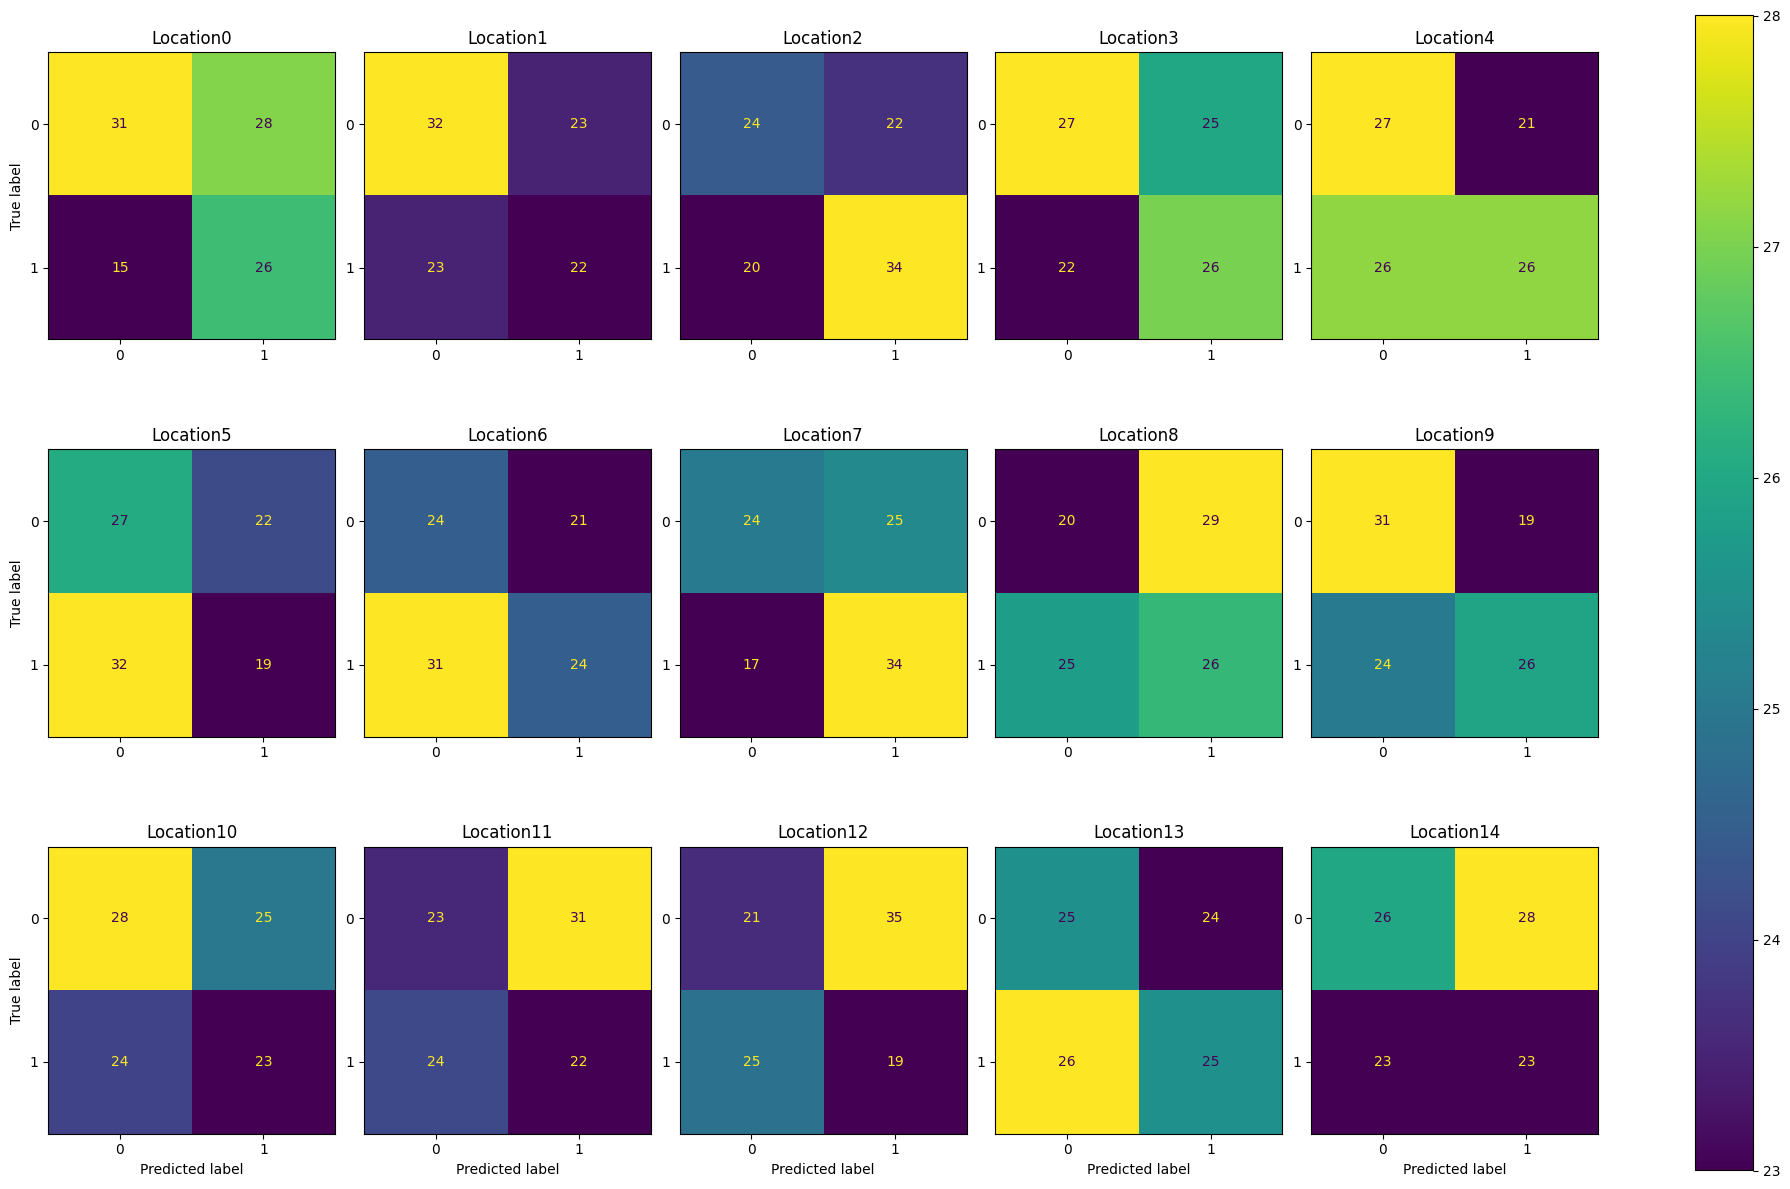

In [237]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Dummy data for illustration
y_test = np.random.randint(0, 2, (100, 15))
lst = np.random.randint(0, 2, (100, 15))
locations = ['Location{}'.format(i) for i in range(15)]

f, axes = plt.subplots(3, 5, figsize=(25, 15))
axes = axes.ravel()

for i in range(15):
    # Calculate confusion matrix
    cm = confusion_matrix(y_test[:, i], lst[:, i])

    # Create display
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[i], values_format='.4g')

    # Set title and adjust labels
    disp.ax_.set_title(locations[i])
    if i < 10:
        disp.ax_.set_xlabel('')
    if i % 5 != 0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

# Adjust layout and add a colorbar
plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes, orientation='vertical')
plt.show()


Comparing the Bayesian model and HAR model based on the confusion matrices reveals the following key points:

1. **Scale and Data Volume**: The HAR model operates on a significantly larger scale, with data counts in the thousands compared to the tens and hundreds in the Bayesian model. This suggests that the HAR model was tested on a much larger dataset.

2. **Model Performance**: The HAR model shows a higher number of correct predictions across most locations, indicating superior performance in accuracy. This is evident from the predominantly yellow and purple areas, which represent true positives and true negatives, respectively.

3. **Error Rates**: The Bayesian model, while showing balanced performance in some locations, generally has higher relative error rates (green and teal areas) compared to the HAR model.

4. **Overall Efficacy**: The HAR model appears to be more effective and robust, possibly due to better training, more extensive data handling, or a more suitable application scenario for its predictive capabilities.

The HAR model, therefore, is recommended for scenarios requiring high accuracy and reliability, provided it is feasible to handle its larger data requirements.

Above is the final confusion matrix
Compare your new values with the ones from your model in Exercise 2.2. Has the optimization helped? Does it seem to be overfitting the data? Record your observations in the same document from Part 1, along with a screenshot of the final confusion matrix.
After Bayesian optimization, the first 15x15 convergence metric was generated, but I question the accuracy of this. If it was overfitted, most of the numbers should be located along the diagonal of the convergence matrix, but instead, this convergence matrix shows a lot of inaccuracies.

**Part 3**

1. In this same document, write out how you might break the data down into smaller components to test and iterate upon. Which model would you use for each iteration?
In Exercise 2.2, you learned that different climate factors have different degrees of importance in different cities. And when we analyzed data from stations across Europe, the accuracy was lower than when we analyzed a single station. Predicting the weather for all of Europe should be done by breaking it down into smaller components and then combining the results. For example, in Exercise 2.2, we used data from other cities with similar climates to clean up missing or strange data.

Hence, I expect that with KNN or K-means clustering, we can divide the European cities into a few clusters. And by analyzing the climate of these clusters, I think we can make more accurate climate predictions for the whole of Europe.

2. Expand on your observations from the random forest and deep learning models.
Random forests and deep learning each have different implications.

The main thing that random forests can tell us is importance. You can see which cities or which climate factors have more influence on pleasant weather. Deep learning models like CNN are thought to be used to learn and predict data.

4. What variables would you recommend that Air Ambulance pay the most attention to while deciding whether it’s safe to fly?
Air Ambulance, which uses helicopters, needs to pay attention to Pleasant day, a climate factor that ClimateWins is primarily interested in. Pleasant day is the most commonly applicable criterion for outdoor activities. In addition, I would recommend that Air Ambulance pay more attention to wind speed, cloud cover, and precipitation. However, since all of these factors combine to determine a pleasant day, I recommend that Air Ambulance also prioritize a pleasant day.